In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Importing in GJ1243 light curve (DR-25)

In [3]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

### Masking out the flares

In [4]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flares = np.where((f_mask == False))[0]

[False False False ... False False False]


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

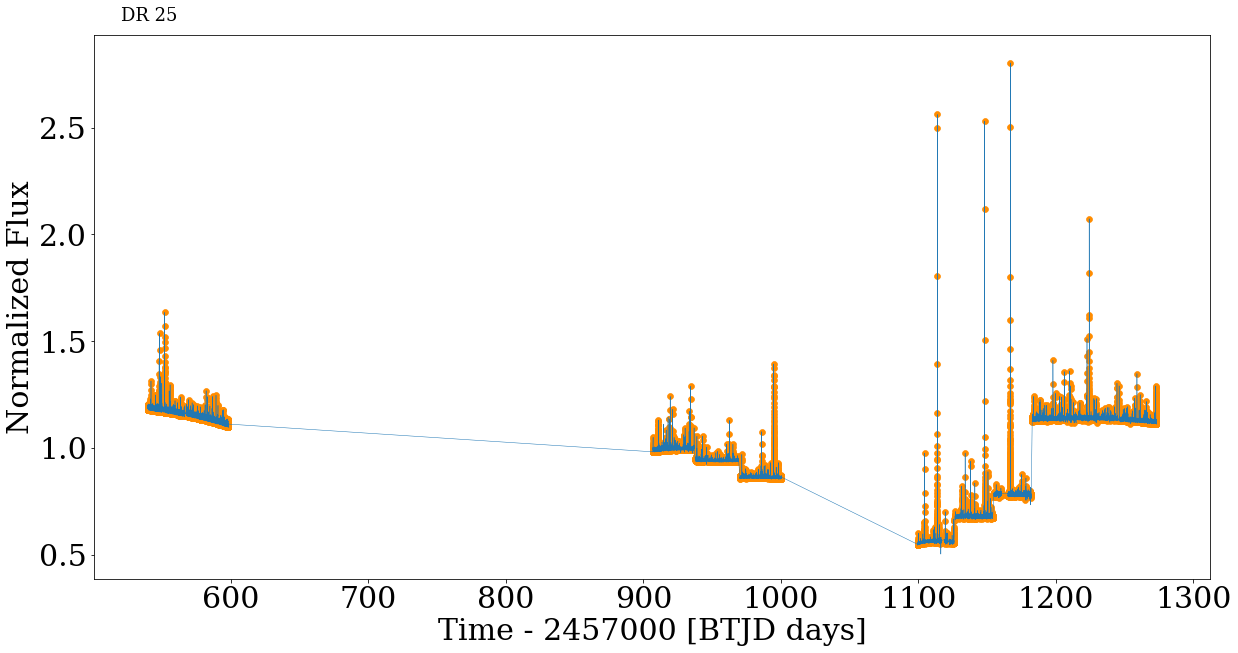

In [5]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)



#Text
plt.text(520, 3, 'DR 25', fontsize=18, color ='k')


plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")


#plt.savefig('gj1243_keplerlc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Accounting for quarterly discontinuities

In [6]:
total_median = np.nanmedian(gj1243lc.flux[no_flares])
raw_flux = 1+((gj1243lc.flux - total_median)/total_median)

In [7]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]
        start = np.min(gj1243_collection[i].time)
        stop = np.max(gj1243_collection[i].time)
        med = np.nanmedian(gj1243lc.flux[no_flares][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [8]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]

        med = 1+((gj1243lc.flux[no_flares][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)


In [9]:
def FlagCuts(flags, bad_flags = (16, 128, 2048)):

    '''
    return the indexes that pass flag cuts

    Ethan says for Kepler cut out [16, 128, 2048], can add more later.
    '''

    # convert flag array to type int, just in case
    flags_int = np.array(flags, dtype='int')
    # empty array to hold places where bad flags exist
    bad = np.zeros_like(flags)

    # these are the specific flags to reject on
    # NOTE: == 2**[4, 7, 11]
    # bad_flgs = [16, 128, 2048]

    # step thru each of the bitwise flags, find where exist
    for k in bad_flags:
        bad = bad + np.bitwise_and(flags_int, k)/k

#     # find places in array where NO bad flags are set
#     if returngood is True:
#         good = np.where((bad < 1))[0]
#         return good
#     else:
    return bad

### Running the Gaussian Process

In [10]:
import celerite
from scipy.optimize import minimize


for i in range (0,len(gj1243_collection)):
        #month is the times of each month w/o flares
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
                         (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)) & 
                         (FlagCuts(gj1243lc.quality[no_flares]) < 1))[0]
        y = medflux[month]
        t = gj1243lc.time[no_flares][month]
        yerr = 1+((gj1243lc.flux_err[no_flares][month] - np.nanmedian(gj1243lc.flux[no_flares][month]))/(np.nanmedian(gj1243lc.flux[no_flares][month])))
        yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
        
        mok = np.where((np.abs(y-np.mean(y)) < 5*np.std(y)))
        y=y[mok]
        t=t[mok]
        yerr=yerr[mok]
        
#         if i==0:
        Q = 0.01
        w0 = 2*np.pi/0.59
        S0 = np.var(y) / (w0 * Q)
        bounds = dict(log_S0=(-15,15), log_Q=(-5,15), log_omega0=(0,15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

#         print(i, np.mean(y), kernel.terms)
        
        #Running the gp
        gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
        gp.compute(t, yerr)  # You always need to call compute once.

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        
#         if i==0:
        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        
#         print(initial_params)
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
#         print(r)
        
        gp.set_parameter_vector(r.x)

        month_flares = np.where((gj1243lc.time >= np.min(gj1243_collection[i].time)) & 
                                (gj1243lc.time <= np.max(gj1243_collection[i].time)))[0]
        x = gj1243lc.time[month_flares]

        #### HOW TO MAKE IT GO SLOW
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        #### HOW TO MAKE IT GO FAST (w/o Variance)
#         pred_mean = gp.predict(y, x, return_cov=False, return_var=False)
#         pred_var = gj1243lc.flux_err[month_flares]/total_median # NOT right, just a hack for right now...

        pred_std = np.sqrt(pred_var)
        #Saving each month of the gp run
        dict_i = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var, 
                'detrended_flux':(1+((gj1243lc.flux[month_flares] - med_nf[i]))/total_median),
                'df_flux_err':(gj1243lc.flux[month_flares])/total_median}  
        gp_out = pd.DataFrame(data=dict_i) 
        gp_out.to_csv(r'gp_values_'+str(i)+'.csv',header=True,index=True)

        #plotting to make sure each month looks reasonable
        plt.figure(figsize=(9,4))
        plt.plot(x,(1+((gj1243lc.flux[month_flares] - med_nf[i]))/total_median))
        plt.plot(t,y, c='C1')
        plt.plot(x,pred_mean, c='r')
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.title(str(i))
        
        plt.xlim(np.min(x),np.min(x) + 7)
        plt.ylim(np.mean(y)-0.025, np.mean(y)+0.05)
        plt.show()
        
        print('>>> ',sum(np.isnan(pred_mean)))
        

0 (39630, 7)
1 (39121, 7)
2 (45254, 7)
3 (45006, 7)
4 (43978, 7)
5 (39984, 7)
6 (32946, 7)
7 (34037, 7)
8 (44060, 7)
9 (42289, 7)
10 (39630, 5)


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


11 (46806, 7)
12 (39630, 5)


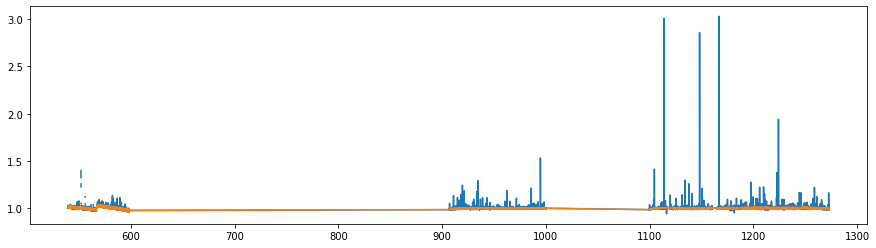

In [5]:
from glob import glob

gp_files = glob('*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

(0.986, 1.03)

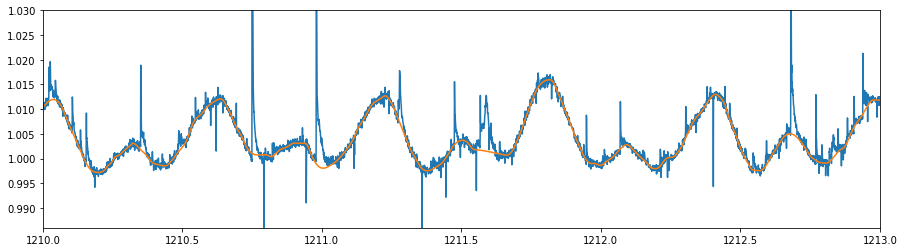

In [6]:
plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.xlim(1210,1213)
plt.ylim(.986,1.03)